<a href="https://colab.research.google.com/github/annafumagalli/LISA-M-project/blob/master/Copy_of_CDAE_spectrograms_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch

In [0]:
%matplotlib inline
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

#from torchsummary import summary
import torch
from torch import nn, optim
from torch.autograd import Variable
import time
from time import strftime, localtime
import copy
import random

In [3]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets

Set 1: mixture of randomly generated sines and sine-gaussians within sensible parameters ranges and NO noise.

## Training

- 100 mixed signals + clean/target sources signals

In [0]:
# Parameters

n = 1000 # number of training/testing datasets 

T = 180     # 3 min of data, sampled every 0.1 s
fs = 10
N = T*fs
t = np.linspace(0,T,N)

# These vary..

# frequency of sine wave
freq_sin = np.random.uniform(0.0, 1.0, n)
# phase of sine wave
phase_shift_sin = np.random.uniform(0.0, 2.0*np.pi, n)
# pulse starting time of sine gaussian
t0_sg = np.random.uniform(0.0, T, n)                  

# These are fixed

#amplitude, phase, frequency and tau of sine gaussian
a = 0.1             
phi0 = np.pi
f0 = 0.5
tau = 10.0

In [0]:
# Time Series (needed for taking ft)

ts_s_train = np.zeros((n,N))
ts_sg_train = np.zeros((n,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(n):
    
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t + phase_shift_sin[i]) #+ noise
    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_train = ts_s_train + ts_sg_train

(1000, 1800)
(1000, 1800)
(1000, 1800)


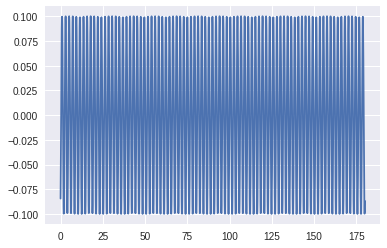

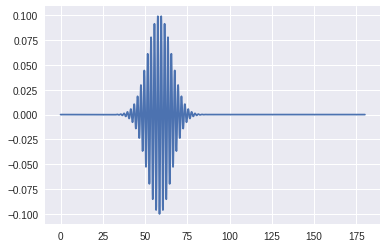

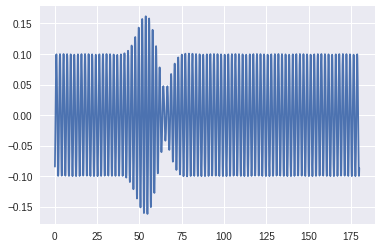

In [6]:
print(ts_s_train.shape)
print(ts_sg_train.shape)
print (ts_mix_train.shape)

# Time series examples

plt.plot(t, ts_s_train[0,:])
plt.show()
plt.plot(t, ts_sg_train[0,:])
plt.show()
plt.plot(t, ts_mix_train[0,:])
plt.show()

In [0]:
# Spectrograms

NFFT = 25*fs   # FTT time interval

NOVL = NFFT*0.8         # overlap

window = np.blackman(NFFT) 

spec_s_train = []
spec_sg_train = []
spec_mix_train = []

for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_s_train.append(temp1)
    
    temp2, _, _ = plt.mlab.specgram(ts_sg_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_sg_train.append(temp2)
    
    temp3, _, _ = plt.mlab.specgram(ts_mix_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_mix_train.append(temp3)

spec_s_train = np.array(spec_s_train)
spec_sg_train = np.array(spec_sg_train)
spec_mix_train = np.array(spec_mix_train)

# Normalise data arrays between [0, 1]

spec_s_train = (spec_s_train - spec_s_train.min())/(spec_s_train.max() - spec_s_train.min())
spec_sg_train = (spec_sg_train - spec_sg_train.min())/(spec_sg_train.max() - spec_sg_train.min())
spec_mix_train = (spec_mix_train - spec_mix_train.min())/(spec_mix_train.max() - spec_mix_train.min())

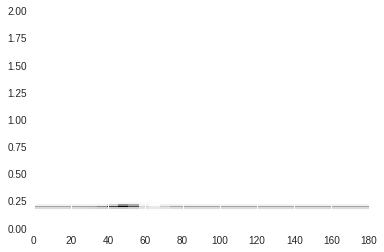

In [8]:
extent = (0.0, 180.0, 0.0, 2.0)

plt.imshow(spec_mix_train[0], aspect='auto', origin='lower', extent=extent)

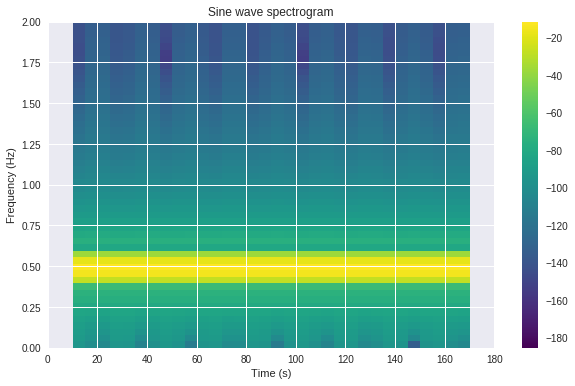

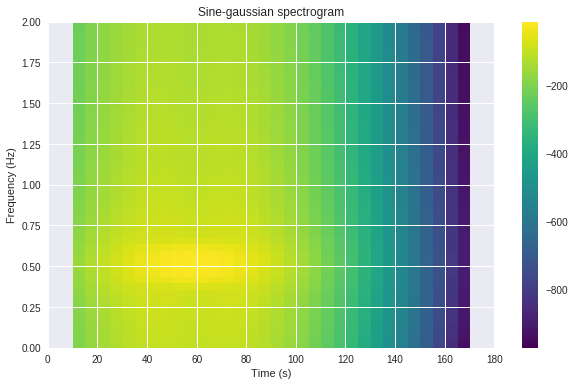

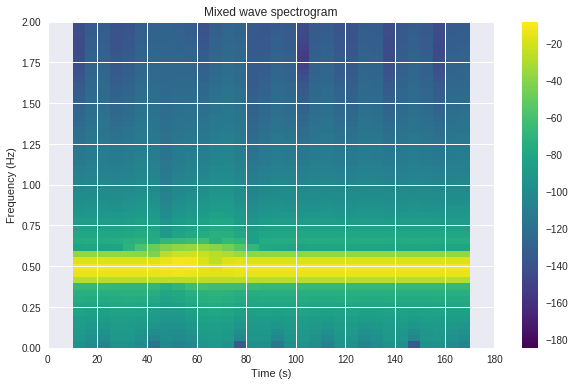

In [9]:
#Prettier spectrograms

spec_cmap='viridis'  # colormap 

# Plot the sine spectrogram:
plt.figure(figsize=(10,6))
spec_s, freqs_s, bins_s, im_s = plt.specgram(ts_s_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, T, 0.0, 2.0])
plt.title('Sine wave spectrogram')

plt.show()

# Plot the sine-gaussian spectrogram:
plt.figure(figsize=(10,6))
spec_sg, freqs_sg, bins_sg, im_sg = plt.specgram(ts_sg_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, T, 0.0, 2.0])
plt.title('Sine-gaussian spectrogram')

plt.show()

# Plot the mixed signal spectrogram:
plt.figure(figsize=(10,6))
spec_mix, freqs_mix, bins_mix, im_mix = plt.specgram(ts_mix_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, T, 0.0, 2.0])
plt.title('Mixed wave spectrogram')

plt.show()

In [10]:
freq_bins = freqs_mix.size    # spectrograms frequency bins
time_frames = bins_mix.size   # spectrograms time frames

print(freq_bins)

126


## Validation

- 20 mixed signals + clean/target sources signals

In [0]:
# Time series (needed for taking ft) 

ts_s_validation = np.zeros((200,N))
ts_sg_validation = np.zeros((200,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(200):
    
    ts_s_validation[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_validation[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_validation = ts_s_validation + ts_sg_validation

In [0]:
# Spectrograms

spec_s_validation = []
spec_sg_validation = []
spec_mix_validation = []

for i in range(20):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_validation[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_s_validation.append(temp1)
    
    temp2, _, _ = plt.mlab.specgram(ts_sg_validation[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_sg_validation.append(temp2)
    
    temp3, _, _ = plt.mlab.specgram(ts_mix_validation[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_mix_validation.append(temp3)

## Testing

- 100 randomly generated useen mixed signals + clean/target sources for evaluation

In [0]:
# Time series (needed for taking ft)

ts_s_test = np.zeros((n,N))
ts_sg_test = np.zeros((n,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(n):
    
    ts_s_test[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_test[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_test = ts_s_test + ts_sg_test

In [0]:
# Spectrograms

spec_s_test = []
spec_sg_test = []
spec_mix_test = []

for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_s_test.append(temp1)
    
    temp2, _, _ = plt.mlab.specgram(ts_sg_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_sg_test.append(temp2)
    
    temp3, _, _ = plt.mlab.specgram(ts_mix_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_mix_test.append(temp3)

spec_s_test = np.array(spec_s_test)
spec_sg_test = np.array(spec_sg_test)
spec_mix_test = np.array(spec_mix_test)

# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

In [0]:
class CDAE(nn.Module):
    
    def __init__(self):
        super(CDAE, self).__init__()
        
        self.encoder = nn.Sequential(
            #input size: [batch_size, 1, H,W=[126,32]]
            nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 10, [126,32]]
            nn.MaxPool2d(kernel_size=(3,2), stride=(3,2)),
            # [batch_size, 10, [42, 16]]
            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 20, [42, 16]]
            nn.MaxPool2d((3,1), (3,1)),
            # [batch_size, 20, [14,16]]
            nn.Conv2d(20, 30, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 30, [14,16]]
            nn.Conv2d(30, 40, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            # [batch_size, 40, [14,16]]
            
        )
        
        self.decoder = nn.Sequential(
            # [batch_size, 40, [14,16]]
            nn.ConvTranspose2d(40, 30, kernel_size=(3,1), stride=(3,1), bias=False),
            nn.Tanh(),
            # [batch_size, 30, [42, 16]]
            nn.ConvTranspose2d(30, 20, kernel_size=(3,2), stride=(3,2), bias=False),
            nn.Tanh(),
            # [batch_size, 20, [126,32]]
            nn.ConvTranspose2d(20, 10, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 10, [126,32]]
            nn.ConvTranspose2d(10, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            # [batch_size, 1, [126,32]]
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

# Training

torch.Size([1000, 1, 126, 32])
torch.Size([1000, 1, 126, 32])
torch.Size([1000, 1, 42, 16])
torch.Size([1000, 1, 14, 16])
torch.Size([1000, 1, 42, 16])
torch.Size([1000, 1, 126, 32])


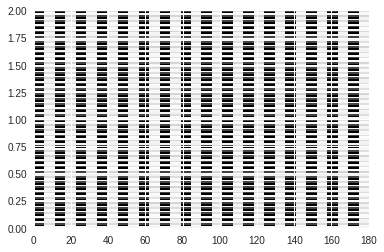

In [17]:
a = Variable(torch.from_numpy(spec_mix_train))
a = a.reshape(n,1,freq_bins,time_frames)
a = a.type(torch.FloatTensor)
m = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
m1 = nn.MaxPool2d((3,2), stride=(3,2))
m2 = nn.MaxPool2d((3,1), stride=(3,1))
m3 = nn.ConvTranspose2d(1, 1, kernel_size=(3,1), stride=(3,1), padding=0)
m4 = nn.ConvTranspose2d(1, 1, kernel_size=(3,2), stride=(3,2), padding=0)

b = m(a)
c = m1(b)
d = m2(c)
e = m3(d)
f = m4(e)

print(a.size())
print(b.size())
print(c.size())
print(d.size())
print(e.size())
print(f.size())

plt.imshow(f[0].reshape(freq_bins,time_frames).detach().numpy(), aspect='auto', origin='lower', extent=extent)
plt.show()

In [0]:
# Hyperparameters

num_epochs = 1000
batch_size = 50
lr = 0.001

epoch 0, loss 0.000864444999024272
None


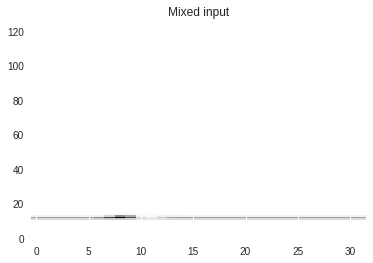

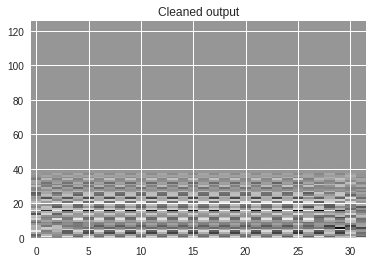

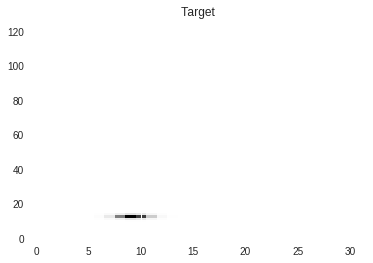

epoch 100, loss 0.0002148212370229885
None


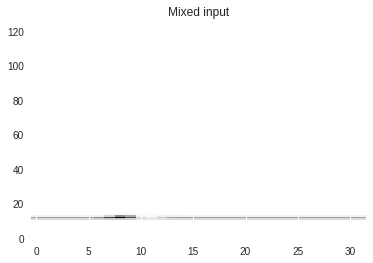

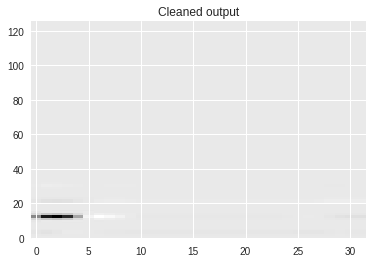

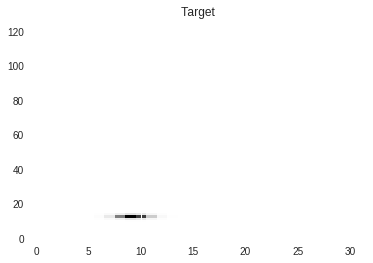

epoch 200, loss 0.00010660069528967142
None


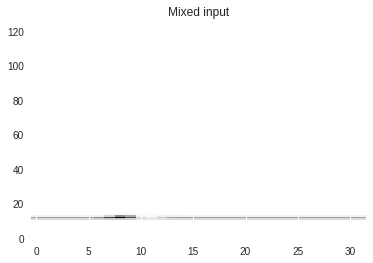

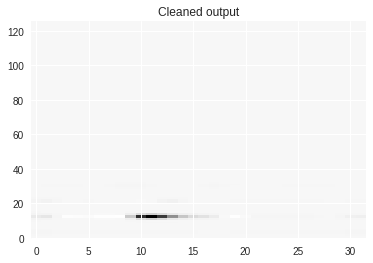

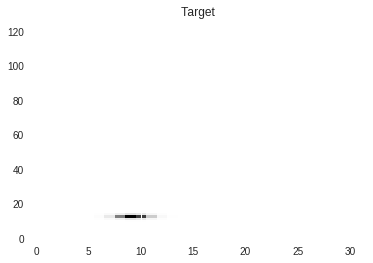

epoch 300, loss 9.354188659926876e-05
None


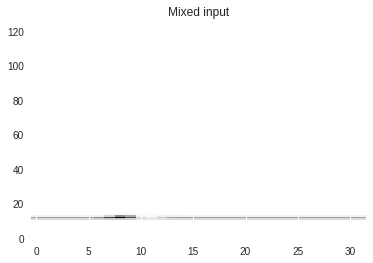

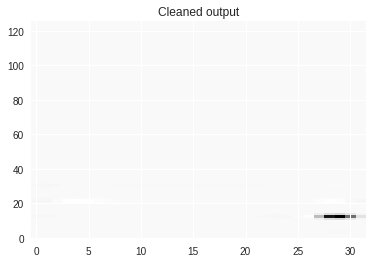

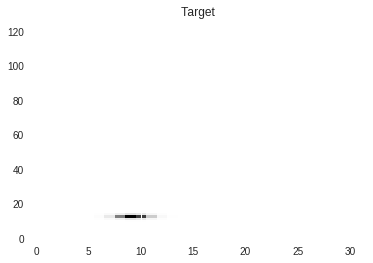

epoch 400, loss 8.746445382712409e-05
None


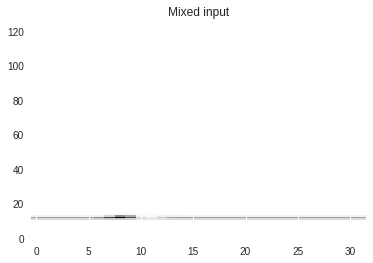

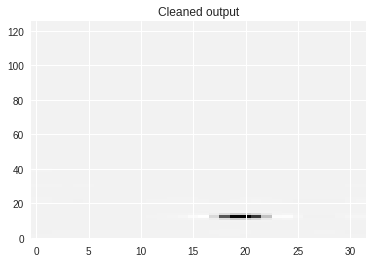

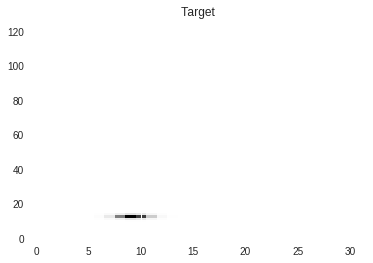

epoch 500, loss 4.975518459104933e-05
None


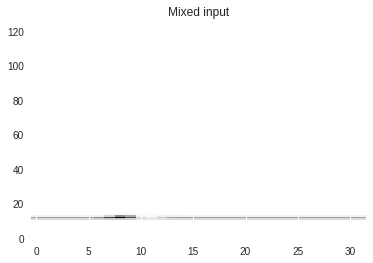

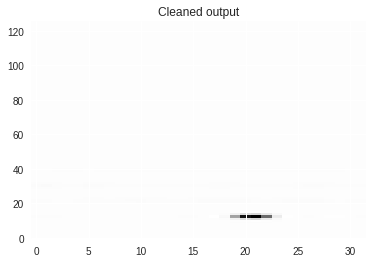

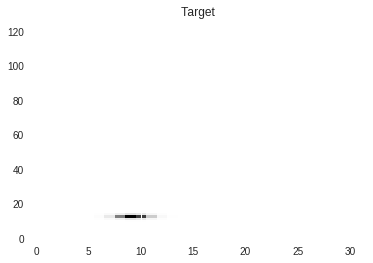

epoch 600, loss 4.7803834604565054e-05
None


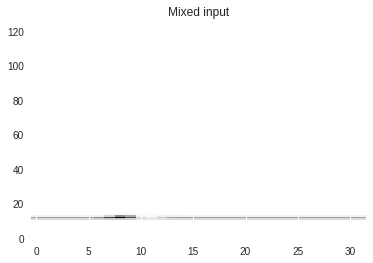

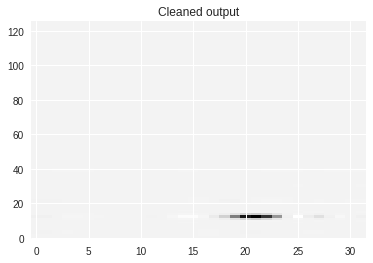

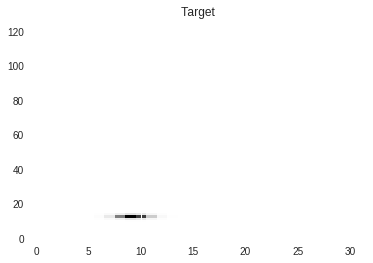

epoch 700, loss 5.307764877215959e-05
None


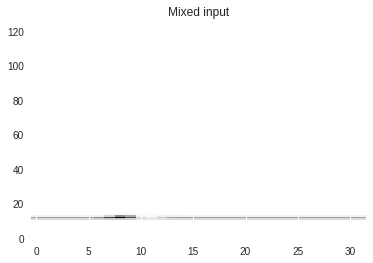

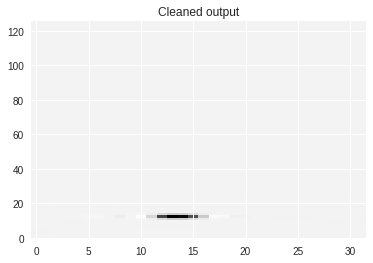

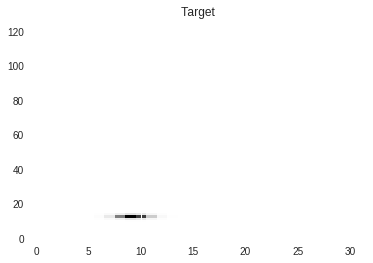

epoch 800, loss 5.160308501217514e-05
None


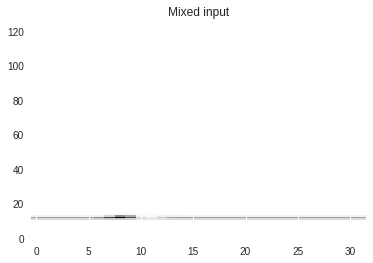

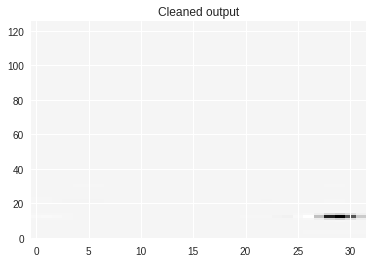

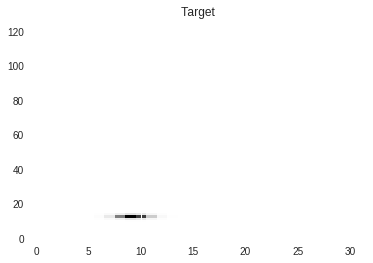

epoch 900, loss 5.26169351360295e-05
None


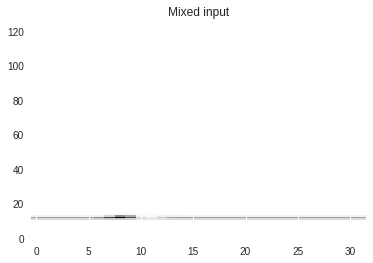

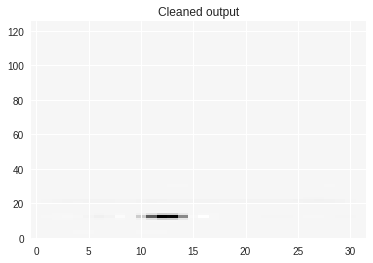

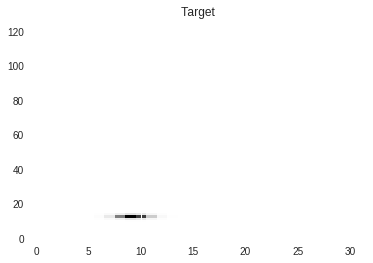

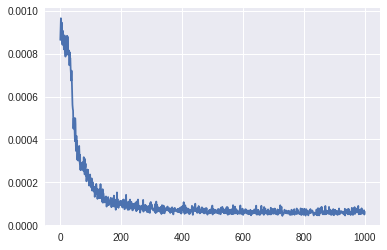

In [25]:
# This net will be trained to separate sine-gaussian waves from the mixed spectrograms

inputs = Variable(torch.from_numpy(spec_mix_train)).to(device)
inputs = inputs.reshape(n,1,freq_bins,time_frames)
inputs = inputs.type(torch.cuda.FloatTensor)
#inputs = inputs.type(torch.FloatTensor)

sg_net = CDAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sg_net.parameters(), lr=lr, weight_decay=1e-5)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    idx  = random.sample(list(np.arange(n)),batch_size) # 20 random indices on the 1000 specs 
    
    outputs = sg_net(inputs[idx,:,:,:])
    
    clean = Variable(torch.from_numpy(spec_sg_train)).to(device)
    clean = clean.reshape(n,1,freq_bins,time_frames)
    clean = clean.type(torch.cuda.FloatTensor)
    #clean = clean.type(torch.FloatTensor)
    
    
    loss = criterion(outputs, clean[idx,:,:,:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_save.append(loss.item())
    
    # monitor progress
    if epoch%100==0:
        print(print('epoch {}, loss {}'.format(epoch, loss.item())))
        
        plt.imshow(inputs[0,:,:,:].reshape(freq_bins,time_frames).cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Mixed input')
        plt.show()
        plt.imshow(outputs[0,:,:,:].reshape(freq_bins,time_frames).detach().cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Cleaned output')
        plt.show()
        plt.imshow(clean[0,:,:].reshape(freq_bins,time_frames).cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Target')
        plt.show()

plt.plot(loss_save)

epoch 0, loss 0.0026107002049684525
None


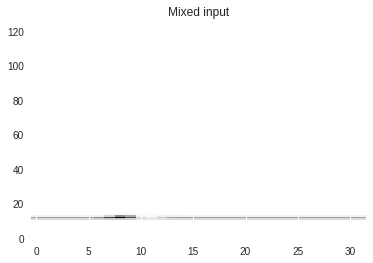

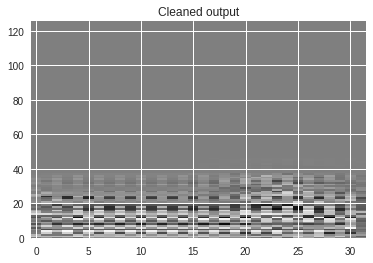

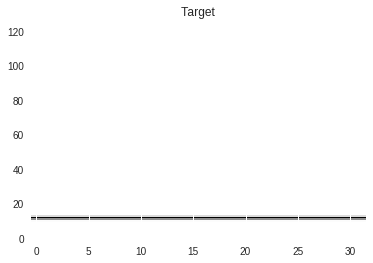

epoch 100, loss 0.0008297149324789643
None


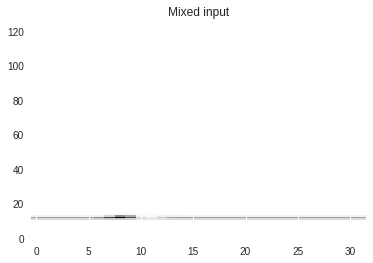

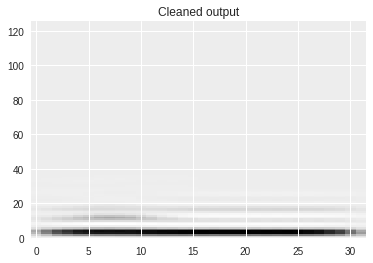

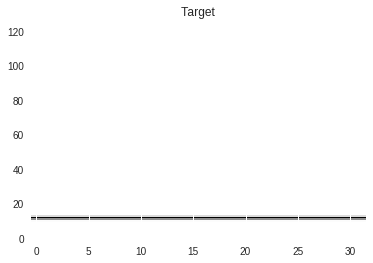

epoch 200, loss 0.0003467503993306309
None


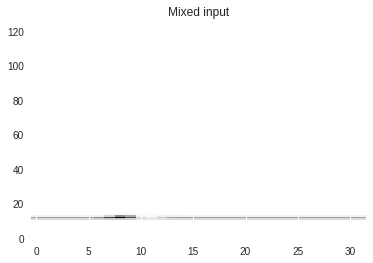

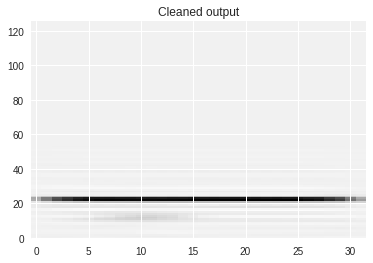

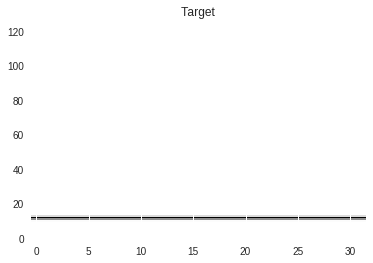

epoch 300, loss 0.0002249306853627786
None


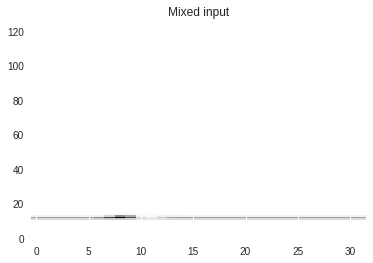

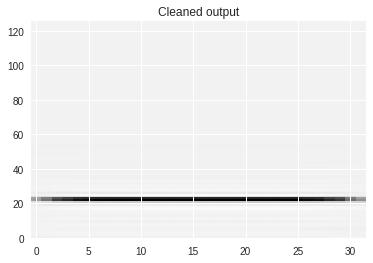

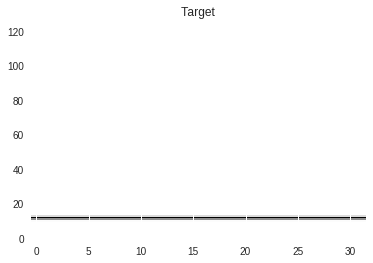

epoch 400, loss 0.00019732359214685857
None


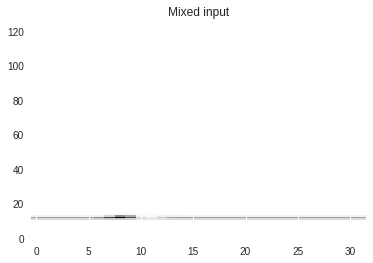

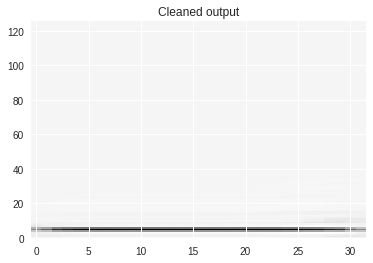

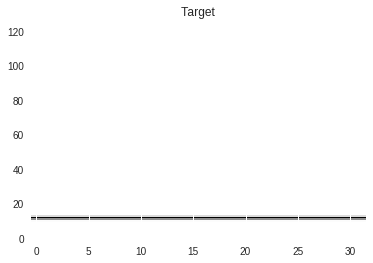

epoch 500, loss 0.00015003274893388152
None


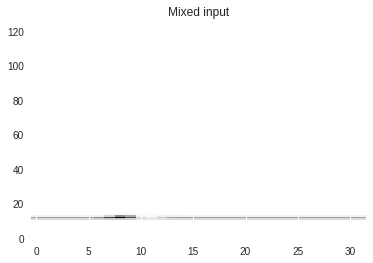

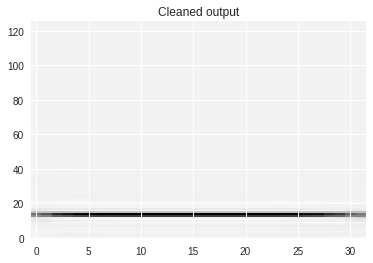

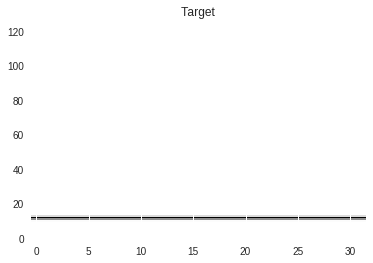

epoch 600, loss 0.00012094929843442515
None


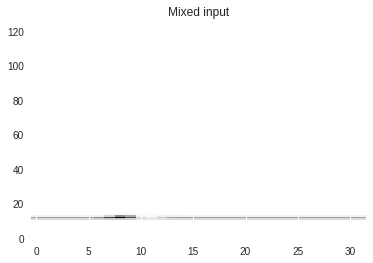

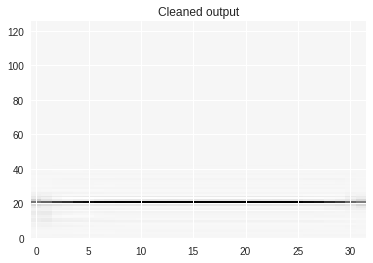

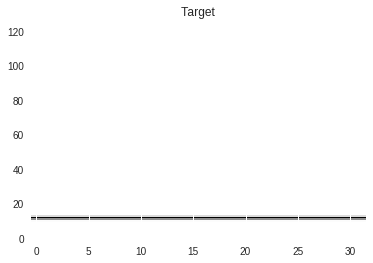

epoch 700, loss 0.00023463390243705362
None


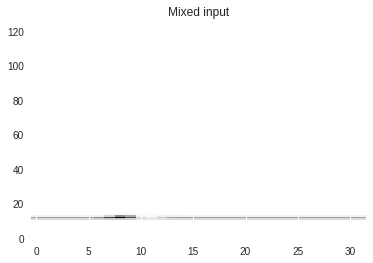

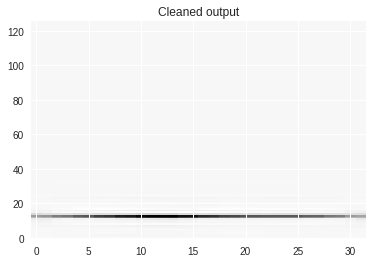

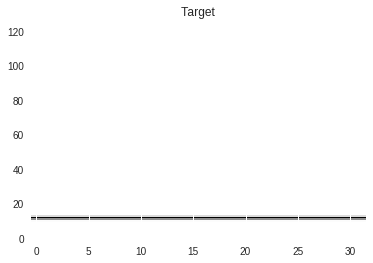

epoch 800, loss 0.00010094016761286184
None


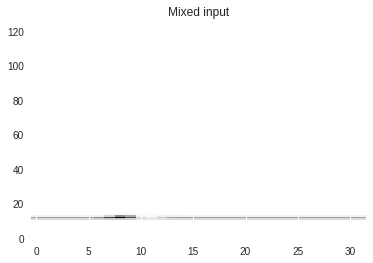

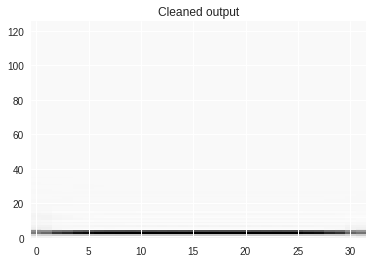

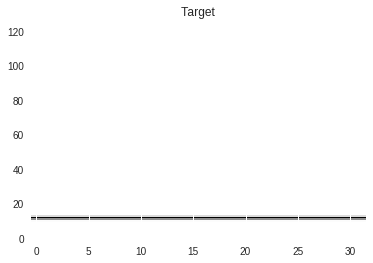

epoch 900, loss 0.00010026078234659508
None


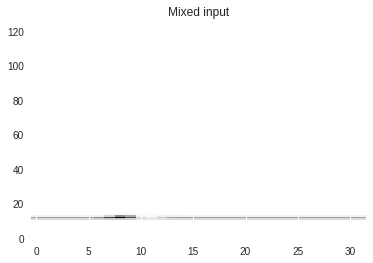

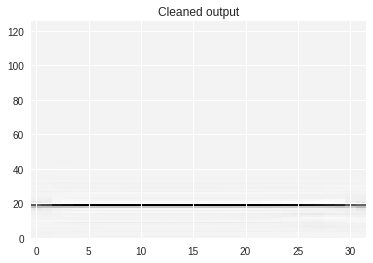

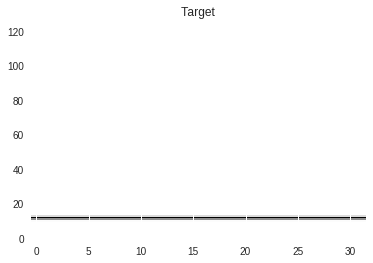

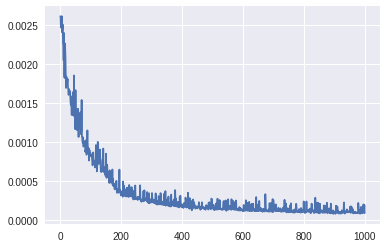

In [23]:
# This net will be trained to separate sine waves from the mixed spectrograms

inputs = Variable(torch.from_numpy(spec_mix_train)).to(device)
inputs = inputs.reshape(n,1,freq_bins,time_frames)
inputs = inputs.type(torch.cuda.FloatTensor)
#inputs = inputs.type(torch.FloatTensor)

s_net = CDAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(s_net.parameters(), lr=lr, weight_decay=1e-5)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    idx  = random.sample(list(np.arange(n)),batch_size) # 20 random indices on the 1000 specs 
    
    outputs = s_net(inputs[idx,:,:,:])
    
    clean = Variable(torch.from_numpy(spec_s_train)).to(device)
    clean = clean.reshape(n,1,freq_bins,time_frames)
    clean = clean.type(torch.cuda.FloatTensor)
    #clean = clean.type(torch.FloatTensor)
    
    
    loss = criterion(outputs, clean[idx,:,:,:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_save.append(loss.item())
    
    # monitor progress
    if epoch%100==0:
        print(print('epoch {}, loss {}'.format(epoch, loss.item())))
        
        plt.imshow(inputs[0,:,:,:].reshape(freq_bins,time_frames).cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Mixed input')
        plt.show()
        plt.imshow(outputs[0,:,:,:].reshape(freq_bins,time_frames).detach().cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Cleaned output')
        plt.show()
        plt.imshow(clean[0,:,:].reshape(freq_bins,time_frames).cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Target')
        plt.show()

plt.plot(loss_save)